In [ ]:
# Based on ST-GCN: https://github.com/yysijie/st-gcn
# Original work by Sijie Yan, Yuanjun Xiong, Dahua Lin (CVPR 2018)

In [ ]:
import numpy as np
import pandas as pd
from data_processing import process_data
from graph import HandOnlyGraph, BodyHandGraph
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import random_split, DataLoader
from collections import Counter
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error, classification_report


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

In [ ]:
import numpy as np

def jitter(x, sigma=0.03):
    noise = np.random.normal(0, sigma, size=x.shape)
    return x + noise

def drop_random_frames(x, drop_ratio=0.1):
    T = x.shape[1]
    keep = np.sort(np.random.choice(T, int(T * (1 - drop_ratio)), replace=False))
    x_dropped = x[:, keep, :]  # correct for 3D [C, T, V]

    # Pad back to original length
    padded = np.zeros_like(x)
    padded[:, :x_dropped.shape[1], :] = x_dropped
    return padded



In [ ]:
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, augment=True):
        self.x = x
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx].copy()  # avoid changing original
        y = self.y[idx]
        if self.augment:
            if np.random.rand() < 0.5:
                x = jitter(x)
            if np.random.rand() < 0.5:
                x = drop_random_frames(x)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


In [ ]:
# get data ready
x_train = np.load(r'/content/drive/MyDrive/Colab Notebooks/CSE-555/UB-CSE-555/models/stgcn/videos_300_train.npy', allow_pickle=True)
x_val = np.load(r'/content/drive/MyDrive/Colab Notebooks/CSE-555/UB-CSE-555/models/stgcn/videos_300_val.npy', allow_pickle=True)
x_test = np.load(r'/content/drive/MyDrive/Colab Notebooks/CSE-555/UB-CSE-555/models/stgcn/videos_300_test.npy', allow_pickle=True)


x_train = x_train.squeeze(-1).astype(np.float32)  # cut the last dimension which is 1
x_val = x_val.squeeze(-1).astype(np.float32)
x_test = x_test.squeeze(-1).astype(np.float32)

df_train = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/CSE-555/UB-CSE-555/models/stgcn/labels_300_train.csv')
df_val = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/CSE-555/UB-CSE-555/models/stgcn/labels_300_val.csv')
df_test = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/CSE-555/UB-CSE-555/models/stgcn/labels_300_test.csv')


label_encoder = LabelEncoder()
all_labels = np.concatenate([df_train["label"], df_val["label"], df_test["label"]])
label_encoder.fit(all_labels)

y_train = label_encoder.transform(df_train["label"]).astype(np.int64)
y_val   = label_encoder.transform(df_val["label"]).astype(np.int64)
y_test  = label_encoder.transform(df_test["label"]).astype(np.int64)



# filter the top 50 words with most videoes
df_all = pd.concat([df_train, df_val, df_test])
top_labels = df_all["label"].value_counts().head(300).index # TOP 50 words

# Filter train/val/test sets
def filter_top(x_data, y_data, top_labels):
    mask = np.isin(label_encoder.inverse_transform(y_data), top_labels)
    return x_data[mask], y_data[mask]

x_train, y_train = filter_top(x_train, y_train, top_labels)
x_val, y_val = filter_top(x_val, y_val, top_labels)
x_test, y_test = filter_top(x_test, y_test, top_labels)

# merge train and val to further increase the size of training
x_train_full = np.concatenate([x_train, x_val], axis=0)
y_train_full = np.concatenate([y_train, y_val], axis=0)

from torch.utils.data import TensorDataset, DataLoader

train_dataset = AugmentedDataset(x_train_full, y_train_full, augment=True)
test_dataset = AugmentedDataset(x_test, y_test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)



In [ ]:
x_train_full.shape

(4325, 2, 64, 42)

In [ ]:
graph = HandOnlyGraph()
adjacency_matrix = graph.get_adjacency_matrix()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class STGCNBlock(nn.Module):
    def __init__(self, in_channel, out_channel, A, stride = 1, residual = True):

        super().__init__()
        self.register_buffer("A", torch.tensor(A, dtype=torch.float32))
        self.gcn = nn.Conv2d(in_channel, out_channel, kernel_size=(1,1))
        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=(9, 1),
                      stride=(stride,1), padding=(4,0)),
            nn.BatchNorm2d(out_channel)
        )


        if not residual:
            self.residual =None
        elif in_channel == out_channel and stride == 1:
            self.residual = nn.Identity()
        else:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=(stride,1)),
                nn.BatchNorm2d(out_channel)
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        A = self.A.to(x.device, non_blocking=True)
        x_gcn = self.gcn(x)
        x_gcn = torch.einsum('nctv,kvw->nctw', x_gcn, A)

        res = 0 if self.residual is None else self.residual(x)
        x_tcn = self.tcn(x_gcn) + res

        return self.relu(x_tcn)


In [ ]:
class STGCN(nn.Module):
    def __init__(self, A, num_classes):
        super().__init__()
        self.data_bn = nn.BatchNorm1d(42 * 2)  # 42 joints × 2 channels
        self.layer1 = STGCNBlock(2, 32, A, residual=False)
        self.layer2 = STGCNBlock(32, 64, A)
        self.layer3 = STGCNBlock(64, 128, A)
        self.layer4 = STGCNBlock(128, 256, A)


        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        n, c, t, v = x.shape
        x = x.permute(0, 3, 1, 2).contiguous().view(n, v * c, t)
        x = self.data_bn(x)
        x = x.view(n, v, c, t).permute(0, 2, 3, 1).contiguous()

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [ ]:

model = STGCN(adjacency_matrix, num_classes=len(label_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # improve try 1
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

In [ ]:
train_acc_list = []
test_acc_list = []

all_preds = []
all_labels = []


In [ ]:
num_epochs = 200
best_test_acc = 0.0

for epoch in range(1, num_epochs + 1):
    # -------- Train --------
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device).long()

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_correct += (preds == batch_y).sum().item()
        train_total += batch_y.size(0)

    train_acc = train_correct / train_total
    avg_loss = train_loss / len(train_loader)

    # -------- Validate --------
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device).long()
            outputs = model(test_x)
            preds = outputs.argmax(dim=1)
            test_correct += (preds == test_y).sum().item()
            test_total += test_y.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(test_y.cpu().numpy())

    test_acc = test_correct / test_total

    print(f"Epoch {epoch:03d} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%} | Loss: {avg_loss:.4f}")

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    # -------- Save Best Model --------
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f">>> Saved new best model with Test Acc: {test_acc:.2%}")

Epoch 001 | Train Acc: 1.04% | Test Acc: 2.63% | Loss: 5.6243
>>> Saved new best model with Test Acc: 2.63%
Epoch 002 | Train Acc: 3.14% | Test Acc: 5.26% | Loss: 5.2501
>>> Saved new best model with Test Acc: 5.26%
Epoch 003 | Train Acc: 5.29% | Test Acc: 4.95% | Loss: 4.9980
Epoch 004 | Train Acc: 6.22% | Test Acc: 5.26% | Loss: 4.8266
Epoch 005 | Train Acc: 8.09% | Test Acc: 8.51% | Loss: 4.7090
>>> Saved new best model with Test Acc: 8.51%
Epoch 006 | Train Acc: 9.34% | Test Acc: 8.82% | Loss: 4.6130
>>> Saved new best model with Test Acc: 8.82%
Epoch 007 | Train Acc: 11.14% | Test Acc: 9.44% | Loss: 4.4929
>>> Saved new best model with Test Acc: 9.44%
Epoch 008 | Train Acc: 12.49% | Test Acc: 11.46% | Loss: 4.4085
>>> Saved new best model with Test Acc: 11.46%
Epoch 009 | Train Acc: 14.45% | Test Acc: 13.62% | Loss: 4.3291
>>> Saved new best model with Test Acc: 13.62%
Epoch 010 | Train Acc: 16.28% | Test Acc: 11.15% | Loss: 4.2474
Epoch 011 | Train Acc: 16.79% | Test Acc: 13.62% 

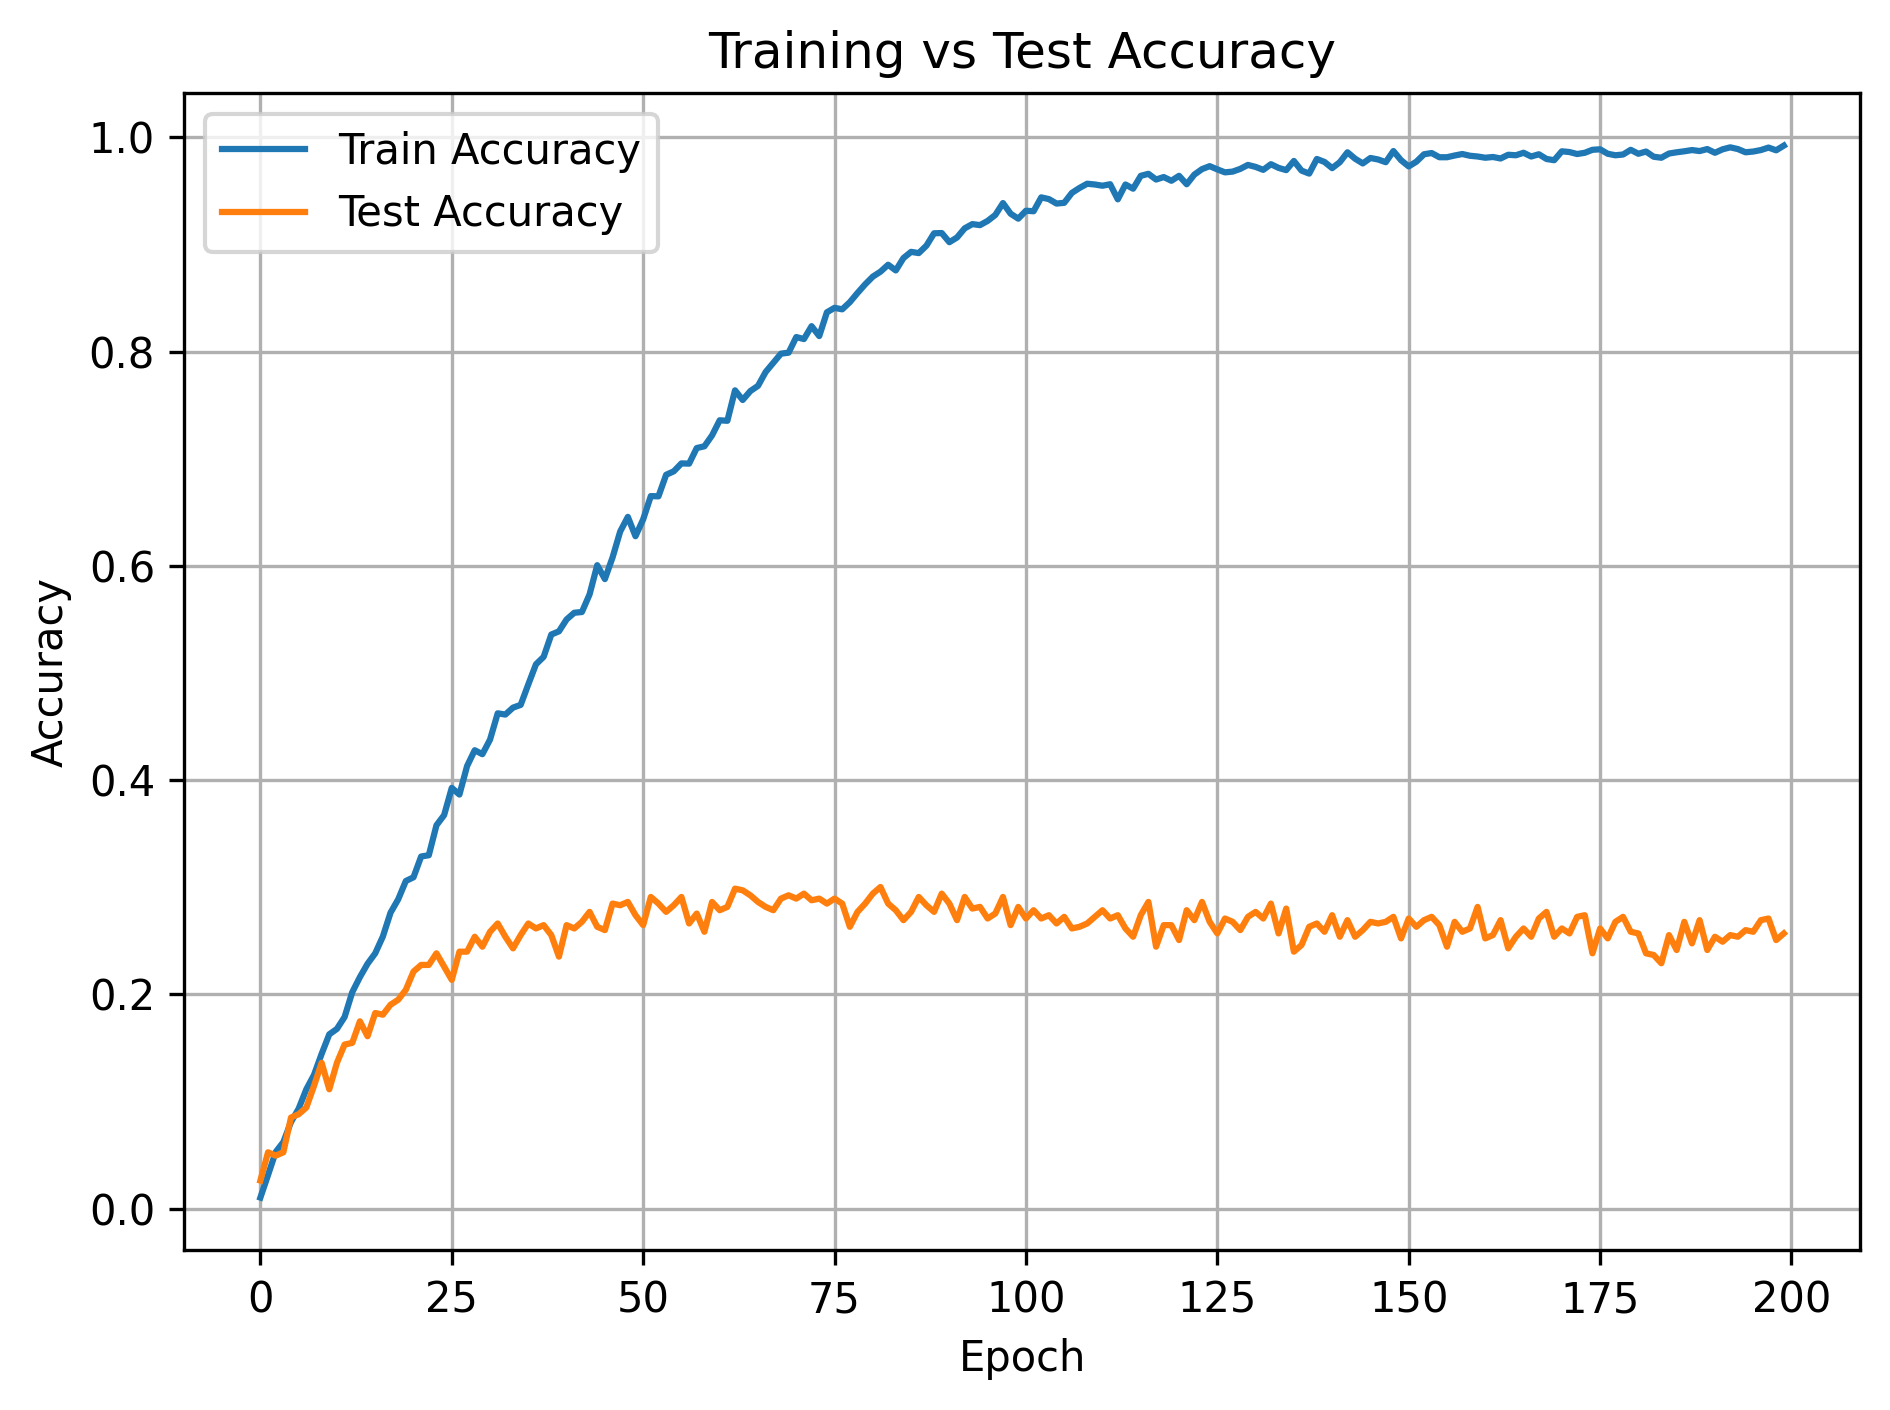

In [ ]:
import matplotlib.pyplot as plt

# actual_epoch = [i for i in range(len(train_acc_list))]
actual_epoch = [i for i in range(200)]


epochs = range(1, num_epochs + 1)
plt.figure(dpi=300)
plt.plot(actual_epoch, train_acc_list[:200], label='Train Accuracy')
plt.plot(actual_epoch, test_acc_list[:200], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# top_labels = df_all["label"].value_counts().head(50).index # TOP 50 words
print(f"length of lables:{len(top_labels)}, labels:{top_labels}")

length of lables:299, labels:Index(['book', 'drink', 'computer', 'go', 'chair', 'before', 'who', 'clothes',
       'candy', 'deaf',
       ...
       'apple', 'all', 'about', 'again', 'arrive', 'animal', 'accident',
       'africa', 'always', 'argue'],
      dtype='object', name='label', length=299)


In [ ]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# F1 Score (macro/weighted)
print("\nF1 Score (macro):", f1_score(all_labels, all_preds, average='macro'))
print("F1 Score (weighted):", f1_score(all_labels, all_preds, average='weighted'))

# Mean Squared Error
print("\nMean Squared Error (MSE):", mean_squared_error(all_labels, all_preds))

# Full Classification Report (includes precision, recall, F1, support)
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

Confusion Matrix:
[[ 34 291   1   8   0  41 204  82  35   1   1   0   0   0   0   0  98   1
    0   3]
 [  2 713   1  17   1   0   0   0   0   0  12   4   0   0   2   0   5   1
   36   6]
 [  0   0 207   0   0   0   4  36 108   0   0   0   3   5   0   3   0 231
    0   3]
 [  0  16   0 520   0   0   0   0   0   0  60   0   0   0   0   1   1   0
    0   2]
 [  5 122  28  21 371   2   0   2   0   4   7   1  24   0   0   0   6   1
    2   4]
 [  8  33   0   1  10 769 166   0   0   0   2   0   0   0   0   2   4   0
    4   1]
 [  0   0   9   0   0  21 529   1  37   0   0   0   0   0   0   0   0   2
    0   1]
 [  0   0 134   0   0   0   0 318  47   0   0   0   3   0   8   1   0  86
    0   3]
 [  1  11   0  37   1   0   3   1 381   0   9 224   0  13   0  12 103   1
    0   3]
 [  1  62  45   3   1   0   8   0   1 205   0   1  41   2  78  57   0   4
   18  73]
 [  9   0   1   1   0  17   0   0  13   1 368  10  13   9   1 148   0   0
    7   2]
 [  1  35   0   3   0   0   0   0   0   2  21 4

In [ ]:
from sklearn.metrics import (
    f1_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    classification_report
)

file_name = "STGCN-300words-42joints_report.txt"
with open(file_name, 'w') as f:
    # f.write("Confusion Matrix:\n")
    # f.write(str(confusion_matrix(all_labels, all_preds)))

    f.write("F1 Score (macro):\n")
    f.write(f"{f1_score(all_labels, all_preds, average='macro'):.4f}\n\n")

    f.write("F1 Score (weighted):\n")
    f.write(f"{f1_score(all_labels, all_preds, average='weighted'):.4f}\n\n")

    f.write("Mean Squared Error (MSE):\n")
    f.write(f"{mean_squared_error(all_labels, all_preds):.4f}\n\n")

    f.write("Mean Absolute Error (MAE):\n")
    f.write(f"{mean_absolute_error(all_labels, all_preds):.4f}\n\n")

    f.write("R^2 Score:\n")
    f.write(f"{r2_score(all_labels, all_preds):.4f}\n\n")

    f.write("Classification Report:\n")
    f.write(classification_report(all_labels, all_preds))

# Save accuracy trends
df_acc = pd.DataFrame({
    "Epoch": np.arange(len(train_acc_list)),
    "Train Accuracy": train_acc_list,
    "Test Accuracy": test_acc_list
})
df_acc.to_csv("STGCN-300words-42joints-accuracy.csv", index=False)

df_preds = pd.DataFrame({
    "True Label": all_labels,
    "Predicted Label": all_preds
})
df_preds.to_csv("STGCN-300words-42joints-predictions.csv", index=False)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# -------- Final Test (optional) --------
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device).long()
        preds = model(x_test).argmax(1)
        test_correct += (preds == y_test).sum().item()
        test_total += y_test.size(0)

test_acc = test_correct / test_total
print(f"\n>>> Final Test Accuracy (best model): {test_acc:.2%}")


>>> Final Test Accuracy (best model): 55.38%


C:\Users\19692\AppData\Local\Temp\ipykernel_40204\1653716947.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
